In [11]:
import pandas as pd
import numpy as np
import os
import time
from sklearn.model_selection import train_test_split


In [3]:
combined_stocks_df = pd.read_csv("filtered_stocks_combined.csv")

combined_stocks_df

,Date,index,Open,High,Low,Close,Volume,OpenInt,ticker
0,2011-01-03,45725,41.600,42.293,41.600,42.204,123930383,0,AAPL
1,2011-01-04,45726,42.579,42.579,42.023,42.426,86135637,0,AAPL
2,2011-01-05,45727,42.260,42.817,42.196,42.772,70669988,0,AAPL
3,2011-01-06,45728,42.902,42.932,42.632,42.739,83619699,0,AAPL
4,2011-01-07,45729,42.787,43.073,42.503,43.045,86506108,0,AAPL
...,...,...,...,...,...,...,...,...,...
75495,2016-12-23,14745947,87.556,87.625,87.201,87.383,4428429,0,XOM
75496,2016-12-27,14745948,87.499,87.768,87.257,87.423,5100402,0,XOM
75497,2016-12-28,14745949,87.354,87.768,86.949,86.989,6834213,0,XOM
75498,2016-12-29,14745950,86.797,87.277,86.728,87.036,6938299,0,XOM


In [4]:
# Convert Date to datetime and set as index
combined_stocks_df["Date"] = pd.to_datetime(combined_stocks_df["Date"])
combined_stocks_df.set_index("Date", inplace=True)

# Drop unnecessary columns if any
combined_stocks_df = combined_stocks_df.drop(columns=["index"])  # Optional

# Pivot to multi-level columns: Ticker as level 1, feature as level 2
stocks_df = combined_stocks_df.pivot_table(
    index=combined_stocks_df.index,
    columns="ticker",
    values=[col for col in combined_stocks_df.columns if col != "ticker"]
)

# Sort columns for clarity
stocks_df = stocks_df.sort_index(axis=1, level=0)

# Swap the column MultiIndex levels
stocks_df_leveled = stocks_df.swaplevel(axis=1)

# Sort by ticker (Level 0)
stocks_df_leveled = stocks_df_leveled.sort_index(axis=1, level=0)

# Preview the new structure
stocks_df_leveled.head()

ticker        AAPL                                                  ABT  \
             Close    High     Low    Open OpenInt       Volume   Close   
Date                                                                      
2011-01-03  42.204  42.293  41.600  41.600     0.0  123930383.0  19.358   
2011-01-04  42.426  42.579  42.023  42.579     0.0   86135637.0  19.540   
2011-01-05  42.772  42.817  42.196  42.260     0.0   70669988.0  19.540   
2011-01-06  42.739  42.932  42.632  42.902     0.0   83619699.0  19.500   
2011-01-07  43.045  43.073  42.503  42.787     0.0   86506108.0  19.582   

ticker                              ...     WMT                              \
              High     Low    Open  ...     Low    Open OpenInt      Volume   
Date                                ...                                       
2011-01-03  19.549  19.338  19.549  ...  46.027  46.089     0.0  16789275.0   
2011-01-04  19.561  19.350  19.448  ...  46.139  46.419     0.0  14296931.0   
2011-01-05  19.764  19.460  19.520  ...  46.174  46.539     0.0  16723328.0   
2011-01-06  19.682  19.342  19.634  ...  45.712  46.166     0.0  18335156.0   
2011-01-07  19.615  19.444  19.489  ...  45.698  45.810     0.0   9374462.0   

ticker         XOM                                              
             Close    High     Low    Open OpenInt      Volume  
Date                                                            
2011-01-03  60.341  60.535  59.604  59.668     0.0  28807445.0  
2011-01-04  60.625  60.665  60.235  60.469     0.0  24744869.0  
2011-01-05  60.462  60.600  60.009  60.430     0.0  20448359.0  
2011-01-06  60.853  61.052  60.439  60.625     0.0  27829692.0  
2011-01-07  61.182  61.431  60.777  60.876     0.0  23838996.0  

[5 rows x 300 columns]

In [5]:
# 3. Time-based split into 60% train, 20% val, 20% test
train_dict, val_dict, test_dict = {}, {}, {}

for ticker in stocks_df_leveled.columns.levels[0]:
    stocks_df_leveled.loc[:, (ticker, 'log_return')] = np.log(
    stocks_df_leveled[ticker]['Close'] / stocks_df_leveled[ticker]['Close'].shift(1)
)

    df = stocks_df_leveled[ticker].dropna().sort_index()
    total_len = len(df)
    train_end = int(total_len * 0.6)
    val_end = train_end + int(total_len * 0.2)

    train_dict[ticker] = df.iloc[:train_end]
    val_dict[ticker] = df.iloc[train_end:val_end]
    test_dict[ticker] = df.iloc[val_end:]

train_df = pd.concat(train_dict, names=["Ticker", "Date"])
val_df = pd.concat(val_dict, names=["Ticker", "Date"])
test_df = pd.concat(test_dict, names=["Ticker", "Date"])

train_df

Close    High     Low    Open  OpenInt       Volume  \
Ticker Date                                                               
AAPL   2011-01-04  42.426  42.579  42.023  42.579      0.0   86135637.0   
       2011-01-05  42.772  42.817  42.196  42.260      0.0   70669988.0   
       2011-01-06  42.739  42.932  42.632  42.902      0.0   83619699.0   
       2011-01-07  43.045  43.073  42.503  42.787      0.0   86506108.0   
       2011-01-10  43.855  43.956  43.179  43.393      0.0  124888228.0   
...                   ...     ...     ...     ...      ...          ...   
XOM    2014-08-04  88.145  88.411  86.542  86.921      0.0   13804459.0   
       2014-08-05  86.445  87.625  86.077  87.492      0.0   14847864.0   
       2014-08-06  87.133  87.723  86.445  86.445      0.0   11264688.0   
       2014-08-07  86.507  87.889  85.944  87.828      0.0   11379351.0   
       2014-08-08  87.800  87.847  86.551  86.947      0.0   12730751.0   

                   log_return  
Ticker Date                    
AAPL   2011-01-04    0.005246  
       2011-01-05    0.008122  
       2011-01-06   -0.000772  
       2011-01-07    0.007134  
       2011-01-10    0.018643  
...                       ...  
XOM    2014-08-04    0.013374  
       2014-08-05   -0.019475  
       2014-08-06    0.007927  
       2014-08-07   -0.007210  
       2014-08-08    0.014836  

[45250 rows x 7 columns]

## LSTM Model

In [6]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.4 MB/s eta 0:00:00


In [12]:
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from kerastuner.tuners import BayesianOptimization

<ipython-input-12-7da7c5882384>:8: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import BayesianOptimization


In [10]:
#Base LSTM

# Function to create sequences for LSTM input
def create_sequences(df, seq_length=10):
    X, y = [], []
    for i in range(len(df) - seq_length):
        X.append(df.iloc[i:i+seq_length, :-1].values)  # Features (excluding target)
        y.append(1 if df.iloc[i+seq_length, -1] > 0 else 0)  # Label: 1 (Long) or 0 (Short)
    return np.array(X), np.array(y)

# Select relevant columns for modeling
features = ["Close", "High", "Low", "Open", "Volume", "log_return"]
target = ["log_return"]

# Normalize features
scaler = StandardScaler()
train_df[features] = scaler.fit_transform(train_df[features])
val_df[features] = scaler.transform(val_df[features])
test_df[features] = scaler.transform(test_df[features])

# Create sequences
seq_length = 10  # Use past 10 days to predict next day
X_train, y_train = create_sequences(train_df[features + target], seq_length)
X_val, y_val = create_sequences(val_df[features + target], seq_length)
X_test, y_test = create_sequences(test_df[features + target], seq_length)

# Shuffle training data
X_train, y_train = shuffle(X_train, y_train, random_state=42)

# Build LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(seq_length, len(features))),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation="relu"),
    Dense(1, activation="sigmoid")  # Binary classification: Long (1) / Short (0)
])

# Compile model
model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

# Train model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")

# Predictions
y_pred = (model.predict(X_test) > 0.5).astype(int)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1414/1414 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - accuracy: 0.4985 - loss: 0.6941 - val_accuracy: 0.5095 - val_loss: 0.6928
Epoch 2/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.5046 - loss: 0.6931 - val_accuracy: 0.5118 - val_loss: 0.6925
Epoch 3/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.5126 - loss: 0.6927 - val_accuracy: 0.5104 - val_loss: 0.6929
Epoch 4/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - accuracy: 0.5135 - loss: 0.6926 - val_accuracy: 0.5106 - val_loss: 0.6927
Epoch 5/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5182 - loss: 0.6920 - val_accuracy: 0.5048 - val_loss: 0.6931
Epoch 6/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.5220 - loss: 0.6915 - val_accuracy: 0.5055 - val_loss: 0.6934
Epoch 7/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.5274 - loss: 0.6908 - val_accuracy: 0.5078 - val_loss: 0.6938
Epoch 8/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.5185 - loss: 0.69

In [13]:
#Rolling Window + Hyperband KT

# Select features and target
features = ["Close", "High", "Low", "Open", "Volume", "log_return"]
target = ["log_return"]

# Normalize features
scaler = StandardScaler()
train_df[features] = scaler.fit_transform(train_df[features])
val_df[features] = scaler.transform(val_df[features])
test_df[features] = scaler.transform(test_df[features])

# Create sequences
seq_length = 10
X_train, y_train = create_sequences(train_df[features + target], seq_length)
X_val, y_val = create_sequences(val_df[features + target], seq_length)
X_test, y_test = create_sequences(test_df[features + target], seq_length)

# Shuffle training data
X_train, y_train = shuffle(X_train, y_train, random_state=42)

# Define model builder function for Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(LSTM(
        units=hp.Int("lstm_units_1", min_value=32, max_value=128, step=32),
        return_sequences=True, input_shape=(seq_length, len(features))
    ))
    model.add(Dropout(hp.Float("dropout_1", 0.1, 0.5, step=0.1)))

    model.add(LSTM(
        units=hp.Int("lstm_units_2", min_value=16, max_value=64, step=16),
        return_sequences=False
    ))
    model.add(Dropout(hp.Float("dropout_2", 0.1, 0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int("dense_units", min_value=8, max_value=32, step=8),
        activation="relu"
    ))

    model.add(Dense(1, activation="sigmoid"))  # Binary classification

    model.compile(
        loss="binary_crossentropy",
        optimizer=Adam(hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])),
        metrics=["accuracy"]
    )

    return model

# Initialize Keras Tuner
tuner = kt.Hyperband(
    build_model,
    objective="val_accuracy",
    max_epochs=20,
    factor=3,
    directory="kt_lstm_tuning",
    project_name="lstm_stock_prediction"
)

# Perform hyperparameter search
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32)

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build and train the final model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

# Evaluate on test data
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")

# Predictions
y_proba = best_model.predict(X_test).flatten()
y_pred = (best_model.predict(X_test) > 0.5).astype(int)

# Evaluation metrics
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"\nAccuracy Score: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")
print("\nConfusion Matrix:")
print(pd.DataFrame(cm,
                  index=['Actual Down', 'Actual Up'],
                  columns=['Predicted Down', 'Predicted Up']))

# ROC Curve visualization
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title('ROC Curve - LSTM Stock Prediction')
plt.show()

Trial 30 Complete [00h 08m 35s]
val_accuracy: 0.5109042525291443

Best val_accuracy So Far: 0.5186834931373596
Total elapsed time: 02h 03m 37s
Epoch 1/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - accuracy: 0.5018 - loss: 0.6939 - val_accuracy: 0.4989 - val_loss: 0.6937
Epoch 2/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.5080 - loss: 0.6930 - val_accuracy: 0.4947 - val_loss: 0.6933
Epoch 3/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - accuracy: 0.5085 - loss: 0.6929 - val_accuracy: 0.5064 - val_loss: 0.6935
Epoch 4/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.5110 - loss: 0.6928 - val_accuracy: 0.5091 - val_loss: 0.6933
Epoch 5/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 39s 14ms/step - accuracy: 0.5143 - loss: 0.6921 - val_accuracy: 0.5066 - val_loss: 0.6927
Epoch 6/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.5101 - loss: 0.6924 - val_accuracy: 0.5104 - val_loss: 0.6929
Epoch 7/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accurac

In [ ]:
#Rolling Window + Bayesian Optimisation

def create_sequences2(df, seq_length=10, step=1):
    X, y = [], []
    for i in range(0, len(df) - seq_length, step):  # Use step in the loop
        X.append(df.iloc[i:i+seq_length, :-1].values)  # Features (excluding target)
        y.append(1 if df.iloc[i+seq_length, -1] > 0 else 0)  # Label: 1 (Long) or 0 (Short)
    return np.array(X), np.array(y)

# Normalize features
scaler = StandardScaler()
train_df[features] = scaler.fit_transform(train_df[features])
val_df[features] = scaler.transform(val_df[features])
test_df[features] = scaler.transform(test_df[features])

# Create sequences with moving window approach
seq_length = 10  # Use past 10 days to predict next day
step = 1  # Moving window step size
X_train, y_train = create_sequences2(train_df[features + target], seq_length, step)
X_val, y_val = create_sequences2(val_df[features + target], seq_length, step)
X_test, y_test = create_sequences2(test_df[features + target], seq_length, step)

# Shuffle training data
X_train, y_train = shuffle(X_train, y_train, random_state=42)

# Define model builder function for Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(LSTM(
        units=hp.Int("lstm_units_1", min_value=32, max_value=128, step=32),
        return_sequences=True, input_shape=(seq_length, len(features))
    ))
    model.add(Dropout(hp.Float("dropout_1", 0.1, 0.5, step=0.1)))

    model.add(LSTM(
        units=hp.Int("lstm_units_2", min_value=16, max_value=64, step=16),
        return_sequences=False
    ))
    model.add(Dropout(hp.Float("dropout_2", 0.1, 0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int("dense_units", min_value=8, max_value=32, step=8),
        activation="relu"
    ))

    model.add(Dense(1, activation="sigmoid"))  # Binary classification

    model.compile(
        loss="binary_crossentropy",
        optimizer=Adam(hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])),
        metrics=["accuracy"]
    )

    return model

#Initialise KT
tuner = BayesianOptimization(
    build_model,
    objective="val_accuracy",
    max_trials=10,  # Limits number of configurations tested
    executions_per_trial=1,
    directory="tuner_results",
    project_name="stock_prediction"
)

# Perform hyperparameter search
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32)

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build and train the final model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

# Evaluate on test data
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")

# Predictions
y_pred = (best_model.predict(X_test) > 0.5).astype(int)

# Calculate model accuracy based on actual next day Open & Close prices
def calculate_accuracy(test_df, y_pred, seq_length):
    correct_predictions = 0
    total_samples = len(y_pred)

    for i in range(seq_length, len(test_df) - 1):
        actual_position = 1 if test_df.iloc[i + 1]['Close'] > test_df.iloc[i + 1]['Open'] else 0
        predicted_position = y_pred[i - seq_length]
        if actual_position == predicted_position:
            correct_predictions += 1

    return correct_predictions / total_samples

# Compute and print accuracy
final_accuracy = calculate_accuracy(test_df, y_pred, seq_length)
print(f"Final Model Accuracy: {final_accuracy:.2f}")

Reloading Tuner from tuner_results/stock_prediction/tuner0.json
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1414/1414 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.5059 - loss: 0.6940 - val_accuracy: 0.4957 - val_loss: 0.6932
Epoch 2/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5093 - loss: 0.6929 - val_accuracy: 0.4989 - val_loss: 0.6931
Epoch 3/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - accuracy: 0.5091 - loss: 0.6931 - val_accuracy: 0.5072 - val_loss: 0.6929
Epoch 4/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.5065 - loss: 0.6928 - val_accuracy: 0.5142 - val_loss: 0.6925
Epoch 5/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.5169 - loss: 0.6922 - val_accuracy: 0.5049 - val_loss: 0.6931
Epoch 6/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.5115 - loss: 0.6927 - val_accuracy: 0.5090 - val_loss: 0.6929
Epoch 7/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 42s 16ms/step - accuracy: 0.5137 - loss: 0.6922 - val_accuracy: 0.5064 - val_loss: 0.6932
Epoch 8/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 39s 14ms/step - accuracy: 0.5171 - loss: 0.69

In [ ]:
#Rolling Window + Bayesian Optimisation KT + Early Stopping

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from keras_tuner.tuners import BayesianOptimization
from sklearn.preprocessing import StandardScaler

# Function to create sequences with step size
def create_sequences2(df, seq_length=10, step=2):  # Step size increased for efficiency
    X, y = [], []
    for i in range(0, len(df) - seq_length, step):
        X.append(df.iloc[i:i+seq_length, :-1].values)
        y.append(1 if df.iloc[i+seq_length, -1] > 0 else 0)
    return np.array(X), np.array(y)

# Normalize features
scaler = StandardScaler()
train_df[features] = scaler.fit_transform(train_df[features])
val_df[features] = scaler.transform(val_df[features])
test_df[features] = scaler.transform(test_df[features])

# Create sequences with step=2 for faster training
seq_length = 10
step = 2
X_train, y_train = create_sequences2(train_df[features + target], seq_length, step)
X_val, y_val = create_sequences2(val_df[features + target], seq_length, step)
X_test, y_test = create_sequences2(test_df[features + target], seq_length, step)


# Optimized Model
def build_model(hp):
    model = Sequential()
    model.add(Bidirectional(LSTM(
        units=hp.Int("lstm_units", min_value=32, max_value=128, step=32),
        return_sequences=True, input_shape=(seq_length, len(features))
    )))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float("dropout_1", 0.2, 0.5, step=0.1)))

    model.add(Bidirectional(LSTM(
        units=hp.Int("lstm_units_2", min_value=16, max_value=64, step=16),
        return_sequences=False
    )))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float("dropout_2", 0.2, 0.5, step=0.1)))

    model.add(Dense(units=hp.Int("dense_units", min_value=8, max_value=32, step=8), activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation="sigmoid"))

    model.compile(
        loss="binary_crossentropy",
        optimizer=Adam(learning_rate=hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])),
        metrics=["accuracy"]
    )
    return model

# Hyperparameter tuning
tuner = BayesianOptimization(
    build_model,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=1,
    directory="tuner_results",
    project_name="stock_prediction"
)

# Run tuning (batch size kept small for sequential data stability)
tuner.search(X_train, y_train, epochs=5, validation_data=(X_val, y_val), batch_size=16)

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# Dynamic Learning Rate Reduction
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)
]

# Train the final model
history = best_model.fit(
    X_train, y_train,
    epochs=20, batch_size=16, validation_data=(X_val, y_val),
    callbacks=callbacks
)

# Evaluate on test data
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")

# Predictions with optimized threshold
y_prob = best_model.predict(X_test)
optimal_threshold = 0.55  # Adjusted for better trade predictions
y_pred = (y_prob > optimal_threshold).astype(int)

# Accuracy Calculation based on next day's stock movement
def calculate_accuracy(test_df, y_pred, seq_length):
    correct_predictions = 0
    total_samples = len(y_pred)  # Use length of predictions, not test_df

    for i in range(total_samples):  # Iterate only over available predictions
        actual_position = 1 if test_df.iloc[i + seq_length]['Close'] > test_df.iloc[i + seq_length]['Open'] else 0
        predicted_position = y_pred[i]
        if actual_position == predicted_position:
            correct_predictions += 1

    return correct_predictions / total_samples

# Compute final accuracy
final_accuracy = calculate_accuracy(test_df, y_pred, seq_length)
print(f"Final Model Accuracy: {final_accuracy:.2f}")

Reloading Tuner from tuner_results/stock_prediction/tuner0.json
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1414/1414 ━━━━━━━━━━━━━━━━━━━━ 57s 32ms/step - accuracy: 0.5075 - loss: 0.7897 - val_accuracy: 0.4964 - val_loss: 0.6960 - learning_rate: 0.0010
Epoch 2/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 83s 33ms/step - accuracy: 0.5046 - loss: 0.7000 - val_accuracy: 0.4947 - val_loss: 0.6956 - learning_rate: 0.0010
Epoch 3/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 47s 33ms/step - accuracy: 0.5120 - loss: 0.6944 - val_accuracy: 0.4995 - val_loss: 0.6937 - learning_rate: 0.0010
Epoch 4/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 81s 33ms/step - accuracy: 0.5081 - loss: 0.6936 - val_accuracy: 0.5011 - val_loss: 0.6939 - learning_rate: 0.0010
Epoch 5/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 81s 32ms/step - accuracy: 0.5074 - loss: 0.6936 - val_accuracy: 0.4957 - val_loss: 0.6934 - learning_rate: 0.0010
Epoch 6/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 44s 31ms/step - accuracy: 0.5104 - loss: 0.6930 - val_accuracy: 0.4992 - val_loss: 0.6935 - learning_rate: 0.0010
Epoch 7/20
1413/1414 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5022 -


Training model for AAPL...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step

Training model for ABT...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step

Training model for ADBE...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step

Training model for AMD...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step

Training model for AMGN...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step

Training model for AMZN...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step

Training model for AXP...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step

Training model for BAC...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step

Training model for BSX...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step

Training model for C...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step

Training model for CAT...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step

Training model for CMCSA...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step

Training model for COST...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step

Training model for CSCO...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step

Training model for CVX...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

Training model for DHR...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step

Training model for DIS...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step

Training model for GE...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step

Training model for GOOGL...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step

Training model for GS...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step

Training model for HD...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step

Training model for HON...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step

Training model for IBM...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step

Training model for INTU...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step

Training model for JNJ...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step

Training model for JPM...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step

Training model for KO...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step

Training model for LLY...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step

Training model for MCD...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step

Training model for MRK...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step

Training model for MSFT...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step

Training model for NVDA...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step

Training model for ORCL...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step

Training model for PEP...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step

Training model for PFE...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step

Training model for PG...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step

Training model for PGR...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step

Training model for QCOM...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step

Training model for SMFG...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step

Training model for SPGI...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step

Training model for SYK...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step

Training model for T...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step

Training model for TMO...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step

Training model for TXN...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step

Training model for UNH...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step

Training model for UNP...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step

Training model for VZ...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step

Training model for WFC...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step

Training model for WMT...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step

Training model for XOM...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

===== OVERALL EVALUATION =====
Accuracy: 0.5119
F1 Score: 0.3550
AUC-ROC: 0.5119

Confusion Matrix:
             Predicted Down  Predicted Up
Actual Down            5531          1866
Actual Up              5285          1968


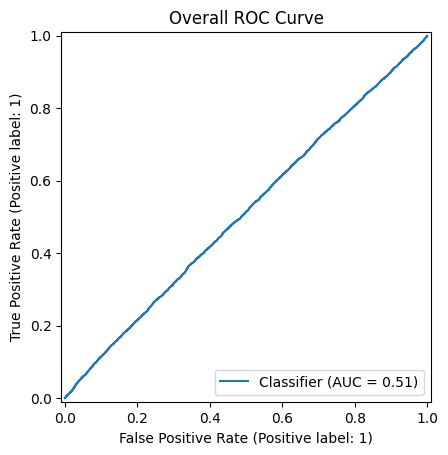

In [9]:
#Rollng Window + Train for each stock

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.optimizers import Adam

# Function to create sequences for LSTM input
def create_sequences(df, seq_length=10):
    X, y = [], []
    for i in range(len(df) - seq_length):
        X.append(df.iloc[i:i+seq_length, :-1].values)
        y.append(1 if df.iloc[i+seq_length, -1] > 0 else 0)
    return np.array(X), np.array(y)

# Set sequence length
seq_length = 10

# Features used in model
features = ["Close", "High", "Low", "Open", "Volume", "log_return"]
target = ["log_return"]

# Split data per stock
ticker_list = stocks_df_leveled.columns.levels[0]
train_dict, val_dict, test_dict = {}, {}, {}

for ticker in ticker_list:
    stocks_df_leveled.loc[:, (ticker, 'log_return')] = np.log(
        stocks_df_leveled[ticker]['Close'] / stocks_df_leveled[ticker]['Close'].shift(1)
    )
    df = stocks_df_leveled[ticker].dropna().sort_index()
    total_len = len(df)
    train_end = int(total_len * 0.6)
    val_end = train_end + int(total_len * 0.2)

    train_dict[ticker] = df.iloc[:train_end]
    val_dict[ticker] = df.iloc[train_end:val_end]
    test_dict[ticker] = df.iloc[val_end:]

train_df = pd.concat(train_dict, names=["Ticker", "Date"])
val_df = pd.concat(val_dict, names=["Ticker", "Date"])
test_df = pd.concat(test_dict, names=["Ticker", "Date"])

# Initialize evaluation containers
all_y_true, all_y_pred, all_y_proba = [], [], []

# Process each stock separately
for ticker in ticker_list:
    print(f"\nTraining model for {ticker}...")

    train_stock = train_df.loc[ticker]
    val_stock = val_df.loc[ticker]
    test_stock = test_df.loc[ticker]

    # Standardize features
    scaler = StandardScaler()
    train_stock[features] = scaler.fit_transform(train_stock[features])
    val_stock[features] = scaler.transform(val_stock[features])
    test_stock[features] = scaler.transform(test_stock[features])

    # Create sequences
    X_train, y_train = create_sequences(train_stock[features + target], seq_length)
    X_val, y_val = create_sequences(val_stock[features + target], seq_length)
    X_test, y_test = create_sequences(test_stock[features + target], seq_length)

    # Skip if insufficient data
    if len(X_train) == 0 or len(X_val) == 0 or len(X_test) == 0:
        print(f"Insufficient data for {ticker}. Skipping.")
        continue

    # Build LSTM model
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(seq_length, len(features))),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        Dense(16, activation="relu"),
        Dense(1, activation="sigmoid")
    ])

    model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

    # Train model
    model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=0)

    # Evaluate model
    y_proba = model.predict(X_test)
    y_pred = (y_proba > 0.5).astype(int)

    # Append to global evaluation lists
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred.flatten())
    all_y_proba.extend(y_proba.flatten())

# ==== Overall Evaluation ====
print("\n===== OVERALL EVALUATION =====")
accuracy = accuracy_score(all_y_true, all_y_pred)
f1 = f1_score(all_y_true, all_y_pred)
auc = roc_auc_score(all_y_true, all_y_proba)
cm = confusion_matrix(all_y_true, all_y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")
print("\nConfusion Matrix:")
print(pd.DataFrame(cm, index=['Actual Down', 'Actual Up'], columns=['Predicted Down', 'Predicted Up']))

# ROC Curve
RocCurveDisplay.from_predictions(all_y_true, all_y_proba)
plt.title('Overall ROC Curve')
plt.show()
